# Grey-box identification of heat transfer dynamics

Last update: 27-07-2023

---

The primary goal of this project is to identify convection effects in a grey-box model of heat transfer dynamics (see system description below), based on temperature measurements throughout the rod.

In [1]:
import Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/sioux/sysid-thermal/CCTA2024-BIDconvection`


## System description

A schematic depiction of the setup is shown in the figure below. 

<p><center><img src='../../system/system-photo.png'/></center></p>

In short, the setup consists of 3 metal blocks which have been lined up, with resistive nylon pads interposed. The temperature can be measured using thermistors at arbitrary places on the setup; for simplicity we assume that we measure the temperature at a single spot on each block, which we call $\tau_1$, $\tau_2$, and $\tau_3$. The temperatures will evolve due to a number of different factors; we will only consider the influence of conduction, convection, radiation, and the user controlled input heat (band heaters).

By assuming that conduction within blocks is so fast that there are no temperature differences within a block, we may model the system using a [lumped-element model](https://en.wikipedia.org/wiki/Lumped-element_model), governed by the following system of ODEs:

$$\frac{d}{dt}\begin{pmatrix} m_1 c_{p, 1} \tau_1 \\ m_2 c_{p, 2} \tau_2 \\ m_3 c_{p, 3} \tau_3 \end{pmatrix} = 
\underbrace{\begin{pmatrix} -k_{12} & k_{12} & 0 \\ k_{12} & -(k_{12} + k_{23}) & k_{23} \\ 0 & k_{23} & -k_{23} \end{pmatrix} \begin{pmatrix} \tau_1 \\ \tau_2 \\ \tau_3 \end{pmatrix}}_{\textrm{conduction}} + \underbrace{\begin{pmatrix} h(\tau_1, \tau_a, 1, t) \\ h(\tau_2, \tau_a, 2, t) \\ h(\tau_3, \tau_a, 3, t) \end{pmatrix}}_{\textrm{convection}} + \underbrace{\sigma \begin{pmatrix} a_1 \varepsilon_1 (\tau_a^4 - \tau_1^4) \\ a_2 \varepsilon_2 (\tau_a^4 - \tau_2^4) \\ a_3 \varepsilon_3 (\tau_a^4 - \tau_3^4) \end{pmatrix}}_{\textrm{radiation}} + \underbrace{\begin{pmatrix} u_1 \\ u_2 \\ u_3 \end{pmatrix}}_{\textrm{input}}.$$

Convection is notoriously hard to model. A coarse approximation would be Newton's law of cooling (Clercx, 2015; Eq. 8.17), which states that convection is linear in the difference between the temperature of the block and the ambient temperature: $h_a (\tau_a - \tau_i)$. With this linear term, we can take steps similar to the identification of the oscillator in Rogers \& Friis (2022), describing the nonlinear function as the combination of a linear term and a "nonlinear remainder":

$$\underbrace{h(\tau_i, \tau_a, i, t)}_{\text{total convection}} = \underbrace{h_a (\tau_a - \tau_i)}_{\text{linear cooling law}} + \underbrace{r(\tau_i, \tau_a, i, t)}_{\text{nonlinear remainder}} \, ,$$

for some constant $h_a$. Furthermore, the role of radiation can often be neglected. With these simplifications, our governing equations become:

$$\frac{d}{dt}\begin{pmatrix} m_1 c_{p, 1} \tau_1 \\ m_2 c_{p, 2} \tau_2 \\ m_3 c_{p, 3} \tau_3 \end{pmatrix} = 
\begin{pmatrix} -k_{12} & k_{12} & 0 \\ k_{12} & -(k_{12} + k_{23}) & k_{23} \\ 0 & k_{23} & -k_{23} \end{pmatrix} \begin{pmatrix} \tau_1 \\ \tau_2 \\ \tau_3 \end{pmatrix} + h_a \begin{pmatrix} a_1 (\tau_a - \tau_1) \\ a_2 (\tau_a - \tau_2) \\ a_3 (\tau_a - \tau_3) \end{pmatrix} + \begin{pmatrix} r(\tau_1, \tau_a, 1, t) \\ r(\tau_2, \tau_a, 2, t) \\ r(\tau_3, \tau_a, 3, t) \end{pmatrix} + \begin{pmatrix} u_1 \\ u_2 \\ u_3 \end{pmatrix},$$

or, more compactly, 

$$ M \dot{z} = K z + h_a a (\tau_a - z) + r(z,\tau_a) + u$$

where $z = [\tau_1 \, , \ \tau_2 \, , \ \tau_3]$.

In these equations, we can distinguish three types of quantities:
1. Measured/observed quantities: e.g. $\tau_i$, $u_i$. These may vary over time, and are known up to a given accuracy due to measurement noise;

2. Known constants: e.g. $m_i$, $c_{p, i}$, $a$, $\tau_a$. These are fully known, and are constant over time. This is reasonable for quantities such as mass $m$ and surface area $a$ (which can be easily measured) and specific heat capacity $c_p$ (which is a material property which according to the Dulong-Petit Law is roughly constant for metals over a long range of temperatures Carter (2000), Ch. 16) Maybe it is less reasonable for the ambient temperature $\tau_a$ (due to e.g. the setup heating up its surroundings);

3. Unknown constants: e.g. $k_{ij}$, $h_a$. These are not known a priori, because there is no simple physical way to measure or derive their values. For example, the conduction coefficients $k_{ij}$ can vary depending on how tightly the blocks have been put together. In this project, we want to identify these constants using Bayesian inference.

In [2]:
using Revise
using DifferentialEquations
using GaussianProcesses
using Distributions
using ForwardDiff
using LaTeXStrings
using LinearAlgebra
using MAT
using Optim
using Polynomials
using Random
using RxInfer

using Plots; default(label="", linewidth=3, margin=15Plots.pt)
include("../util/discretization.jl");

## Data simulation

In [3]:
# Time parameters
T = 600
Δt = 1.0
tsteps = range(0.0, step=Δt, length=T)

# Constants
true_mcp_1 = 1e3
true_mcp_2 = 1e3
true_mcp_3 = 1e3
true_a_1 = 1.0
true_a_2 = 1.0
true_a_3 = 1.0
true_k12 = 50.
true_k23 = 10.
true_h_a = 10.0
true_τ_a = 19.
true_R   = 1e-1*diagm(ones(3))

# Input heat parameters
true_b = [750.0, 0., 0.]

3-element Vector{Float64}:
 750.0
   0.0
   0.0

In [4]:
# Temperature inputs
τr = range(00, stop=90, step=0.5)
NN = length(τr)

# Kernel hyperparameters
l_true = 1000.
λ_true = sqrt(3)/l_true
γ_true = 50.

# Kernel
κ(τ,τ_prime) = γ_true^2 .*exp.(-λ_true.*abs.(τ - τ_prime))
K = zeros(NN,NN)
for ii in 1:NN
    for jj in 1:NN
        K[ii,jj] = κ(τr[ii], τr[jj])
    end
end

# Inverse of kernel
Ki = inv(K + 1e-3*diagm(ones(NN)))

# Generate targets for Gaussian Process
# r(z,i,τ_a) = min(0,((τ_a - (10-2i) -z[1])^3)./2)
# r(z,i,τ_a) = min(0,((τ_a - z)^3)./i)
r(z,i,τ_a) = (τ_a - z)^3 ./ 100
targets1 = r.(τr, 1, true_τ_a) 
targets2 = r.(τr, 2, true_τ_a) 
targets3 = r.(τr, 3, true_τ_a) 

# GP Predictive distribution
pred_mean_block1(τ) = dot(κ.(τ,τr), Ki*targets1)
pred_mean_block2(τ) = dot(κ.(τ,τr), Ki*targets2)
pred_mean_block3(τ) = dot(κ.(τ,τr), Ki*targets3)

pred_mean_block3 (generic function with 1 method)

In [5]:
# heatmap(K)

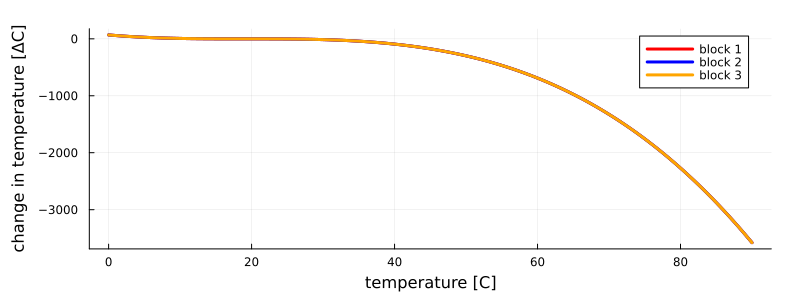

In [6]:
# Simulate nonlinear convection function
dτr1 = pred_mean_block1.(τr)
dτr2 = pred_mean_block2.(τr)
dτr3 = pred_mean_block3.(τr)

plot(xlabel="temperature [C]", ylabel="change in temperature [ΔC]", size=(800,300))
plot!(τr, dτr1, color="red", label="block 1")
plot!(τr, dτr2, color="blue", label="block 2")
plot!(τr, dτr3, color="orange", label="block 3")

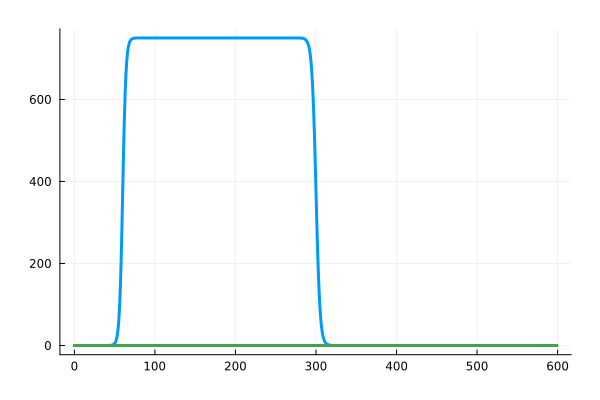

In [7]:
function u(t::Float64, b::Float64; i::Int64=1) 
    "Constant heater"
    return b
end

function u(t::Float64, b::Float64, t_on::Float64; i::Int64=1, β::Float64=0.1) 
    "Turn on heater"
    return b ./(1+exp(-β*(t - t_on))) 
end

function u(t::Float64; i::Int64=1, b::Float64=1.0, t_on::Float64=20., t_off::Float64=60., β1::Float64=0.6, β2::Float64=0.4) 
    "Pulse heater"
    return b ./(1+exp(-β1*(t - t_on))) * exp(-β2*(t - t_off))./(1+exp(-β2*(t - t_off)))
end

t_onset = 60.
t_offset = 300.
β = 0.5

# Generate functions
u1(t) = u.(t, b=true_b[1], t_on=t_onset, t_off=t_offset, i=1, β1=β)
u2(t) = u.(t, b=true_b[2], t_on=t_onset, t_off=t_offset, i=2, β1=β)
u3(t) = u.(t, b=true_b[3], t_on=t_onset, t_off=t_offset, i=3, β1=β)
  
inputs = hcat([[u1(k); u2(k); u3(k)] for k in tsteps]...)

plot(tsteps, inputs')

In [8]:
function NONLCONV(dz, z, params, t)
    "Lumped-element model with nonlinear convection term"

    # Extract parameters
    mcp_1, mcp_2, mcp_3, a_1, a_2, a_3, τ_a, k12, k23, h_a = params
    
    # Conduction
    dz[1] = (-k12*z[1] +      k12 *z[2]            ) / mcp_1
    dz[2] = ( k12*z[1] - (k12+k23)*z[2] + k23 *z[3]) / mcp_2
    dz[3] = (                 k23 *z[2] - k23 *z[3]) / mcp_3
    
    # Convection - linear
    dz[1] += h_a * a_1 * (τ_a - z[1]) / mcp_1
    dz[2] += h_a * a_2 * (τ_a - z[2]) / mcp_2
    dz[3] += h_a * a_3 * (τ_a - z[3]) / mcp_3 
    
    # Convection - nonlinear
    dz[1] += pred_mean_block1(z[1]) / mcp_1
    dz[2] += pred_mean_block2(z[2]) / mcp_2
    dz[3] += pred_mean_block3(z[3]) / mcp_3
    
    # Input heat
    dz[1] += u1(t) / mcp_1
    dz[2] += u2(t) / mcp_2
    dz[3] += u3(t) / mcp_3
end

NONLCONV (generic function with 1 method)

In [9]:
sysparams = [true_mcp_1, 
             true_mcp_2, 
             true_mcp_3, 
             true_a_1, 
             true_a_2, 
             true_a_3,
             true_τ_a, 
             true_k12, 
             true_k23, 
             true_h_a]

τ_0 = [true_τ_a, true_τ_a, true_τ_a]

# Solve the system numerically using DifferentialEquations.jl
sys_NONLCONV = ODEProblem(NONLCONV, τ_0, (tsteps[1], tsteps[end]), sysparams)
states = Array(solve(sys_NONLCONV, RK4(); saveat=tsteps, verbose = true))

3×600 Matrix{Float64}:
 19.0  19.0  19.0  19.0  19.0  19.0  …  19.7752  19.7674  19.7596  19.7519
 19.0  19.0  19.0  19.0  19.0  19.0     19.7706  19.7629  19.7554  19.748
 19.0  19.0  19.0  19.0  19.0  19.0     19.7654  19.7578  19.7503  19.7429

In [10]:
# Noisy measurements
measurements = zeros(3,T)
for k = 1:T
    measurements[:,k] = states[:,k] + cholesky(true_R).L*randn(3)
end

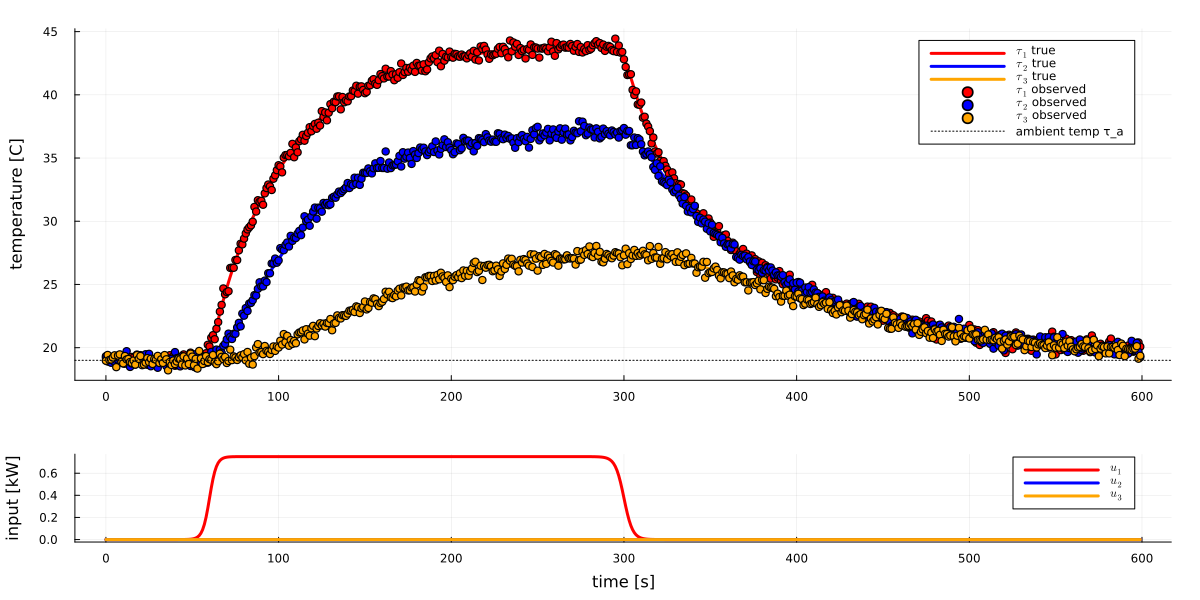

In [11]:
p101 = plot(xlabel="", ylabel="temperature [C]")
plot!(tsteps, states', linecolors = ["red" "blue" "orange"], labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"], )
scatter!(tsteps, measurements', markercolors = ["red" "blue" "orange"], labels = [L"$τ_1$ observed" L"$τ_2$ observed" L"$τ_3$ observed"])
hline!([true_τ_a], color="black", linewidth=1, linestyle=:dot, label="ambient temp τ_a")

p102 = plot(xlabel = "time [s]", ylabel = "input [kW]")
plot!(tsteps, inputs' ./ 1000, linecolors = ["red" "blue" "orange"], labels = [L"$u_1$" L"$u_2$" L"$u_3$"], )

plot(p101, p102, layout=grid(2,1, heights=[0.8, 0.2]), size=(1200,600))

In [12]:
output_ = [measurements[:,k] for k in 1:T];
inputs_ = [[true_τ_a; inputs[:,k]] for k in 1:T];

In [13]:
@model function SSM(A, B, C, Q, R, m0, S0; T=1)
    
    x = randomvar(T)
    u = datavar(Vector{Float64}, T)
    y = datavar(Vector{Float64}, T)
    
    x_0 ~ MvNormalMeanCovariance(m0, S0)
    x_kmin1 = x_0
    for k = 1:T
        
        x[k] ~ MvNormalMeanCovariance(A*x_kmin1 + B*u[k], Q)
        y[k] ~ MvNormalMeanCovariance(C*x[k], R)
        
        x_kmin1 = x[k]
    end
end

In [39]:
Dx = 3
Du = 4
Dy = 3

M  = [true_mcp_1          0           0;
     0           true_mcp_2           0;
     0                    0  true_mcp_3]
K  = [-true_k12       true_k12                0;
       true_k12  -(true_k12+true_k23)  true_k23;
              0       true_k23        -true_k23]
An = [true_a_1, true_a_2, true_a_3]

F  = inv(M)*(K - true_h_a*diagm(An))
G  = inv(M)*[true_h_a*An diagm(ones(Dx))]

λ_star = λ_true
γ_star = γ_true

A  = exp(F*Δt)
B  = G*Δt
C  = diagm(ones(Dy))
Q  = 1e-12*diagm(ones(Dx))
R  = true_R*diagm(ones(Dy))

m0 = τ_0
S0 = diagm(ones(Dx))

results = infer(
    model       = SSM(A, B, C, Q, R, m0, S0, T=T),
    data        = (y = output_, u = inputs_),
    options     = (limit_stack_depth = 100,),
    free_energy = true,
)

Inference results:
  Posteriors       | available for (x_0, x)
  Free Energy:     | Real[83637.9]


In [40]:
qx = results.posteriors[:x]
fitx_v = cat( var.(qx)..., dims=2)
fitx_m = cat(mean.(qx)..., dims=2)

3×600 Matrix{Float64}:
 17.0587  17.0835  17.1077  17.1314  …  20.275   20.2632  20.2515  20.2399
 17.1543  17.1718  17.1895  17.2073     20.2734  20.2616  20.25    20.2384
 17.4403  17.4539  17.4675  17.4809     20.2602  20.2487  20.2374  20.2261

In [41]:
FMSE_GPSSM = mean((fitx_m - states).^2)
println("Smoothed MSE states and fit: $FMSE_GPSSM")

Smoothed MSE states and fit: 9.15866044246645


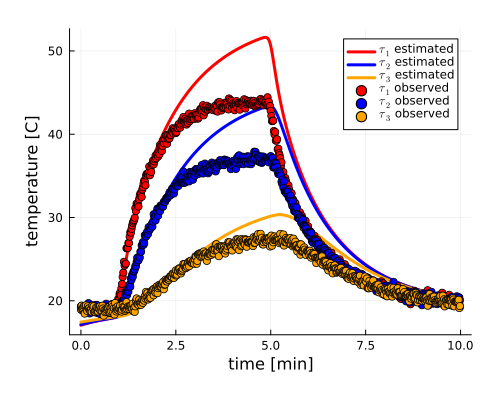

In [47]:
plot(tsteps ./ 60,
     fitx_m';
     ribbon=sqrt.(fitx_v)',
     legend = true, 
     # title="GPSSM Smoothed MSE = $FMSE_GPSSM",
     linecolors = ["red" "blue" "orange"], 
     fillcolors = ["red" "blue" "orange"], 
     labels = [L"$τ_1$ estimated" L"$τ_2$ estimated" L"$τ_3$ estimated"],
     xlabel = "time [min]", 
     ylabel = "temperature [C]",
     size=(500,400)
)
# plot!(tsteps, 
#       transpose(states), 
#       alpha = 0.3,
#       linecolors = ["red" "blue" "orange"], 
#       linestyle = :dash,
#       labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"],
# )
# plot!(tsteps, states', linecolors = ["red" "blue" "orange"], labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"], )
scatter!(tsteps ./ 60, measurements', markercolors = ["red" "blue" "orange"], labels = [L"$τ_1$ observed" L"$τ_2$ observed" L"$τ_3$ observed"])
# hline!([true_τ_a], color="black", linewidth=1, linestyle=:dot, label="ambient temp τ_a")


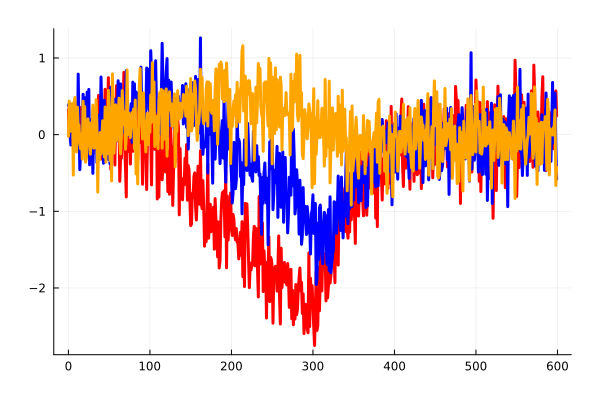

In [18]:
# Post-measurement residuals
residuals = measurements - C*fitx_m

plot(tsteps, residuals[1,:], color="red")
plot!(tsteps, residuals[2,:], color="blue")
plot!(tsteps, residuals[3,:], color="orange")

### Fit GP to residuals

In [20]:
# Fit GP 
# hparams = [log(λ_true), log(γ_true)]
hparams = [1.,1.]

gp1 = GP(tsteps, residuals[1,:], MeanZero(), Mat12Iso(hparams...), log(sqrt(R[1,1])))
gp2 = GP(tsteps, residuals[2,:], MeanZero(), Mat12Iso(hparams...), log(sqrt(R[2,2])))
gp3 = GP(tsteps, residuals[3,:], MeanZero(), Mat12Iso(hparams...), log(sqrt(R[3,3])))

GP Exact object:
  Dim = 1
  Number of observations = 600
  Mean function:
    Type: MeanZero, Params: Float64[]
  Kernel:
    Type: Mat12Iso{Float64}, Params: [1.0, 1.0]
  Input observations = 
[0.0 1.0 … 598.0 599.0]
  Output observations = [-0.02197553095363247, 0.43724836159104186, 0.04376122587987297, 0.07368304207897225, 0.22864748780718713, 0.4090868284261404, -0.5273268487865117, 0.3860665040317848, 0.48415108563083464, -0.09807104408578127  …  -0.5252236456488291, 0.07833715455466717, 0.04720150269807988, 0.029258023841460812, -0.005319504866875491, 0.08714669955389098, 0.11618216500710687, 0.3221101522703691, -0.6638660157809255, -0.4220323247148059]
  Variance of observation noise = 0.10000000000000002
  Marginal Log-Likelihood = -978.766

In [21]:
# optimize!(gp1; method=ConjugateGradient())
# optimize!(gp2; method=ConjugateGradient())
# optimize!(gp3; method=ConjugateGradient())

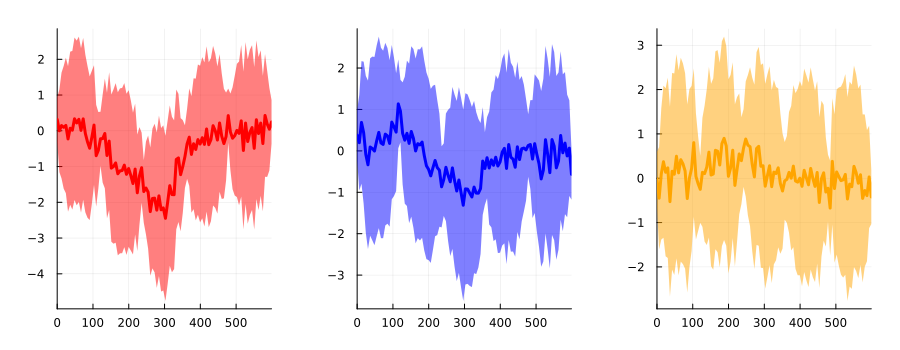

In [22]:
p1 = plot(gp1, obsv=false, color="red", fillcolor="red")
p2 = plot(gp2, obsv=false, color="blue", fillcolor="blue")
p3 = plot(gp3, obsv=false, color="orange", fillcolor="orange")
plot(p1,p2,p3, layout=(1,3), size=(900,350))

In [23]:
rGP_1 = predict_y(gp1, tsteps)[1]
rGP_2 = predict_y(gp2, tsteps)[1]
rGP_3 = predict_y(gp3, tsteps)[1]

deg = 3

f1_pol3 = Polynomials.fit(fitx_m[1,:], rGP_1, deg)
f2_pol3 = Polynomials.fit(fitx_m[2,:], rGP_2, deg)
f3_pol3 = Polynomials.fit(fitx_m[3,:], rGP_3, deg)
# f1_pol3 = Polynomials.fit(measurements[1,:], rGP_1, deg)
# f2_pol3 = Polynomials.fit(measurements[2,:], rGP_2, deg)
# f3_pol3 = Polynomials.fit(measurements[3,:], rGP_3, deg)

Polynomial(41.13981964444317 - 5.504260226155687*x + 0.2431317092998565*x^2 - 0.003536537215326745*x^3)

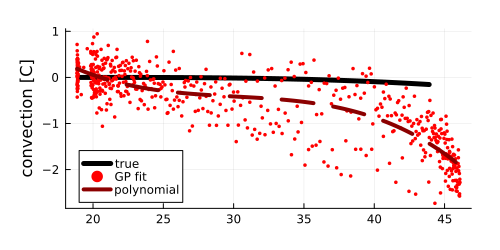

In [24]:
plot(xlabel="",
     ylabel="convection [C]",
     # yticks=(range(-1000,stop=0.0, length=5), round.(range(-1000,stop=0.0, length=5).*Δt./true_mcp_1, digits=2)),
     size=(500,250),
     legend=:bottomleft,
     )
plot!(states[1,:], r.(states[1,:],1,true_τ_a) ./ true_mcp_1, linewidth=5, color="black", alpha=1., label="true")
# plot!(fitx_m[1,:], fitx_m[4,:], ribbon=sqrt.(fitx_v[4,:]), color="red", alpha=0.5, fillalpha=0.5, label="GP")
scatter!(fitx_m[1,:], rGP_1, alpha=1., markerstrokewidth=0, markersize=2, label="GP fit", color="red")
# scatter!(fitx_m[1,:], samples_f1[2:end,:]', alpha=0.05, markerstrokewidth=0, markersize=3, label="", color="red")
plot!(sort(fitx_m[1,:]), x -> f1_pol3(x), linewidth=4, color="darkred", linestyle=:dash, label="polynomial")

In [25]:
savefig("figures/SSM+GPr-block1_fnest.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/sioux/sysid-thermal/CCTA2024-BIDconvection/experiment-simulated/figures/SSM+GPr-block1_fnest.png"

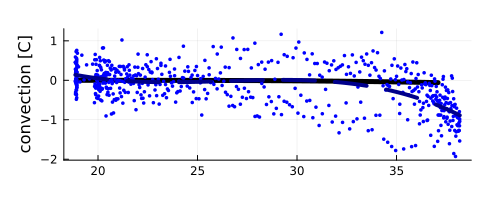

In [26]:
plot(xlabel="",
     ylabel="convection [C]",
     # yticks=(range(-1000,stop=0.0, length=5), round.(range(-1000,stop=0.0, length=5).*Δt./true_mcp_1, digits=2)),
     size=(500,200),
     legend=:false,
     )
plot!(states[2,:], r.(states[2,:],1,true_τ_a) ./ true_mcp_2, linewidth=5, color="black", alpha=1., label="true")
# plot!(fitx_m[1,:], fitx_m[4,:], ribbon=sqrt.(fitx_v[4,:]), color="red", alpha=0.5, fillalpha=0.5, label="GP")
scatter!(fitx_m[2,:], rGP_2, alpha=1., markerstrokewidth=0, markersize=2, label="GP fit", color="blue")
# scatter!(fitx_m[2,:], samples_f2[2:end,:]', alpha=0.05, markerstrokewidth=0, markersize=3, label="", color="blue")
plot!(sort(fitx_m[2,:]), x -> f2_pol3(x), linewidth=4, color="darkblue", linestyle=:dash, label="polynomial")

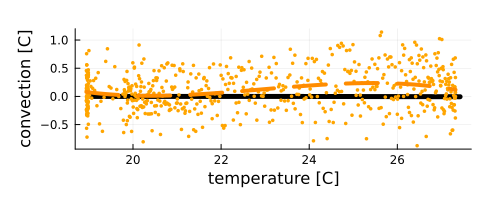

In [28]:
plot(xlabel="temperature [C]",
     ylabel="convection [C]",
     # yticks=(range(-1000,stop=0.0, length=5), round.(range(-1000,stop=0.0, length=5).*Δt./true_mcp_1, digits=2)),
     size=(500,200),
     legend=:false,
     )
plot!(states[3,:], r.(states[3,:],1,true_τ_a) ./ true_mcp_3, linewidth=5, color="black", alpha=1., label="true")
# plot!(fitx_m[1,:], fitx_m[4,:], ribbon=sqrt.(fitx_v[4,:]), color="red", alpha=0.5, fillalpha=0.5, label="GP")
scatter!(fitx_m[3,:], rGP_3, alpha=1., markerstrokewidth=0, markersize=2, label="GP fit", color="orange")
# scatter!(fitx_m[2,:], samples_f2[2:end,:]', alpha=0.05, markerstrokewidth=0, markersize=3, label="", color="blue")
plot!(sort(fitx_m[3,:]), x -> f3_pol3(x), linewidth=4, color="darkorange", linestyle=:dash, label="polynomial")

## Model validation

### Simulation with true function to generate validation data

In [30]:
N_val = 900
tsteps_val = range(0.0, step=Δt, length=N_val)

t_onset_val = 120.
t_offset_val = 360.
β = 0.5

# Generate functions
# u1(t) = u.(t, b=true_b[1], t_on=t_onset, t_off=t_offset, i=1, β1=β)
u1_val(t) = u.(t, b=true_b[1], t_on=t_onset_val, t_off=t_offset_val, i=1, β1=β)
u2_val(t) = u.(t, b=true_b[2], t_on=t_onset_val, t_off=t_offset_val, i=2, β1=β)
u3_val(t) = u.(t, b=true_b[3], t_on=t_onset_val, t_off=t_offset_val, i=3, β1=β)

inputs_val = hcat([[u1_val(k); u2_val(k); u3_val(k)] for k in tsteps_val]...)

3×900 Matrix{Float64}:
 6.56738e-24  1.08278e-23  1.7852e-23  …  2.59949e-91  1.74249e-91
 0.0          0.0          0.0            0.0          0.0
 0.0          0.0          0.0            0.0          0.0

In [31]:
function NONLCONV_val(dz, z, params, t)
    "Lumped-element model with nonlinear convection term"

    # Extract parameters
    mcp_1, mcp_2, mcp_3, a_1, a_2, a_3, τ_a, k12, k23, h_a = params
    
    # Conduction
    dz[1] = (-k12*z[1] +      k12 *z[2]            ) / mcp_1
    dz[2] = ( k12*z[1] - (k12+k23)*z[2] + k23 *z[3]) / mcp_2
    dz[3] = (                 k23 *z[2] - k23 *z[3]) / mcp_3
    
    # Convection - linear
    dz[1] += h_a * a_1 * (τ_a - z[1]) / mcp_1
    dz[2] += h_a * a_2 * (τ_a - z[2]) / mcp_2
    dz[3] += h_a * a_3 * (τ_a - z[3]) / mcp_3
    
    # Convection - nonlinear
    dz[1] += pred_mean_block1(z[1]) ./ mcp_1
    dz[2] += pred_mean_block2(z[2]) ./ mcp_2
    dz[3] += pred_mean_block3(z[3]) ./ mcp_3
    
    # Input heat
    dz[1] += u1_val(t) / mcp_1
    dz[2] += u2_val(t) / mcp_2
    dz[3] += u3_val(t) / mcp_3
end

NONLCONV_val (generic function with 1 method)

In [32]:
sysparams = [true_mcp_1, 
             true_mcp_2, 
             true_mcp_3, 
             true_a_1, 
             true_a_2, 
             true_a_3, 
             true_τ_a, 
             true_k12, 
             true_k23, 
             true_h_a]

τ0_val = [40., 40., 40.]
sys_NONLCONV = ODEProblem(NONLCONV_val, τ0_val, (tsteps_val[1], tsteps_val[end]), sysparams)
states_val = Array(solve(sys_NONLCONV, RK4(); saveat=tsteps_val, verbose = true))

measurements_val = states_val + cholesky(true_R).L*randn(size(states_val))

3×900 Matrix{Float64}:
 39.8919  39.5852  39.1606  38.8201  …  18.8591  19.3624  18.8446  19.3925
 39.9675  39.6962  39.3974  39.1375     19.3184  19.1538  19.1544  18.7529
 39.9954  39.5696  39.2185  39.0625     19.1815  19.4653  19.224   18.992

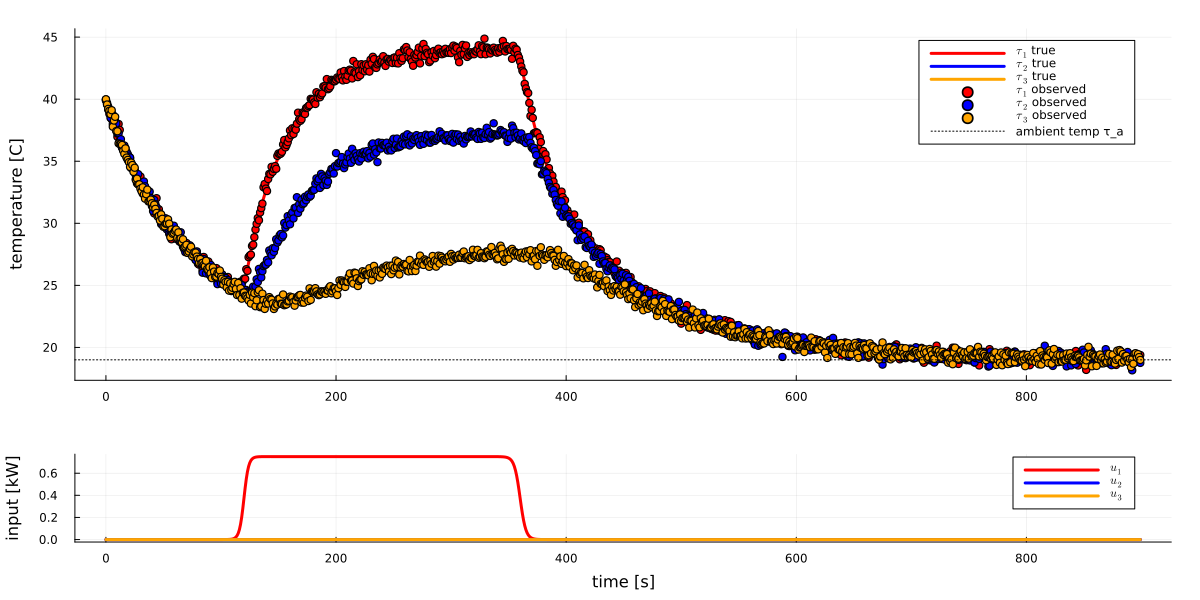

In [33]:
p101 = plot(xlabel="", ylabel="temperature [C]")
plot!(tsteps_val, states_val', linecolors = ["red" "blue" "orange"], labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"], )
scatter!(tsteps_val, measurements_val', markercolors = ["red" "blue" "orange"], labels = [L"$τ_1$ observed" L"$τ_2$ observed" L"$τ_3$ observed"])
hline!([true_τ_a], color="black", linewidth=1, linestyle=:dot, label="ambient temp τ_a")

p102 = plot(xlabel = "time [s]", ylabel = "input [kW]")
plot!(tsteps_val, inputs_val' ./ 1000, linecolors = ["red" "blue" "orange"], labels = [L"$u_1$" L"$u_2$" L"$u_3$"], )

plot(p101, p102, layout=grid(2,1, heights=[0.8, 0.2]), size=(1200,600))

### Simulation by identified model

In [34]:
function NONLCONV_idsim(dz, z, params, t)
    "Lumped-element model with nonlinear convection term"

    # Extract parameters
    mcp_1, mcp_2, mcp_3, a_1, a_2, a_3, τ_a, k12, k23, h_a = params
    
    # Conduction
    dz[1] = (-k12*z[1] +      k12 *z[2]            ) / mcp_1
    dz[2] = ( k12*z[1] - (k12+k23)*z[2] + k23 *z[3]) / mcp_2
    dz[3] = (                 k23 *z[2] - k23 *z[3]) / mcp_3
    
    # Convection - linear
    dz[1] += h_a * a_1 * (τ_a - z[1]) / mcp_1
    dz[2] += h_a * a_2 * (τ_a - z[2]) / mcp_2
    dz[3] += h_a * a_3 * (τ_a - z[3]) / mcp_3
    
    # Convection - nonlinear
    dz[1] += f1_pol3(z[1]) #./ mcp_1
    dz[2] += f2_pol3(z[2]) #./ mcp_2
    dz[3] += f3_pol3(z[3]) #./ mcp_3
    
    # Input heat
    dz[1] += u1_val(t) / mcp_1
    dz[2] += u2_val(t) / mcp_2
    dz[3] += u3_val(t) / mcp_3
end

idNONLCONV = ODEProblem(NONLCONV_idsim, τ0_val, (tsteps_val[1], tsteps_val[end]), sysparams)
sim_states = Array(solve(idNONLCONV, Tsit5(); saveat=tsteps_val, verbose = true))

3×900 Matrix{Float64}:
 40.0  38.9661  38.0171  37.1418  …  20.6449  20.6454  20.6459  20.6463
 40.0  38.5816  37.5041  36.6497     21.206   21.2056  21.2053  21.2051
 40.0  33.1207  31.1185  30.1152     27.1478  27.1479  27.148   27.148

### Compare true and identified 

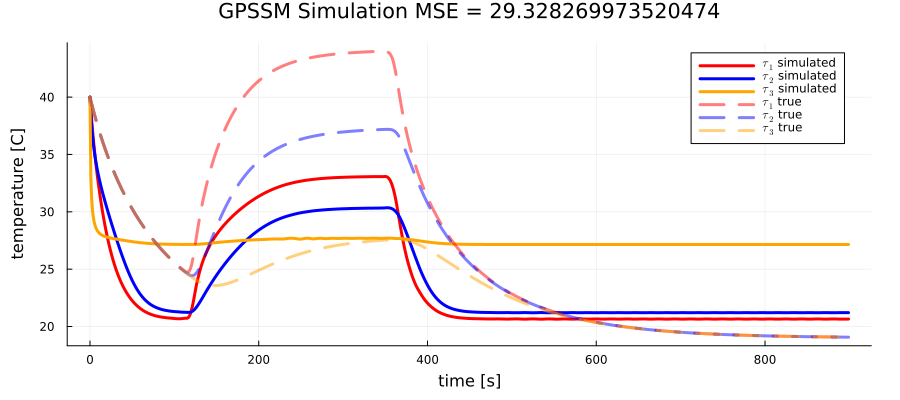

In [35]:
SMSE_GPSSM = mean((sim_states - states_val).^2)

plot(tsteps_val,
     sim_states';
     legend = true, 
     title = "GPSSM Simulation MSE = $SMSE_GPSSM",
     linecolors = ["red" "blue" "orange"], 
     fillcolors = ["red" "blue" "orange"], 
     labels = [L"$τ_1$ simulated" L"$τ_2$ simulated" L"$τ_3$ simulated"],
     xlabel = "time [s]", 
     ylabel = "temperature [C]",
     size=(900,400)
)
plot!(tsteps_val, 
      transpose(states_val), 
      alpha = 0.5,
      linecolors = ["red" "blue" "orange"], 
      linestyle = :dash,
      labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"],
)


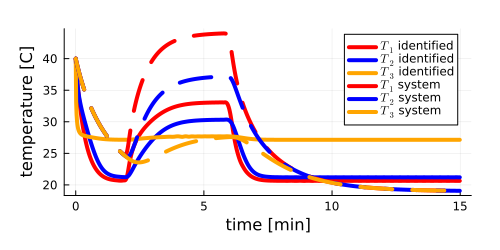

In [36]:
plot(tsteps_val ./ 60,
     sim_states';
     legend = true, 
     linewidth=4,
    #  title = "GPSSM Simulation MSE = $SMSE_GPSSM",
     linecolors = ["red" "blue" "orange"], 
     fillcolors = ["red" "blue" "orange"], 
     labels = [L"$T_1$ identified" L"$T_2$ identified" L"$T_3$ identified"],
     xlabel = "time [min]", 
     ylabel = "temperature [C]",
     size=(500,250)
)
plot!(tsteps_val ./ 60, 
      transpose(states_val), 
      linewidth=4,
      alpha = 1.,
      linecolors = ["red" "blue" "orange"], 
      linestyle = :dash,
      labels = [L"$T_1$ system" L"$T_2$ system" L"$T_3$ system"],
)
